Unsupervised clustering offers a powerful method for identifying patterns and categorizing data within satellite imagery, without prior labeling. Google Earth Engine (GEE) provides a robust platform for implementing these unsupervised clustering algorithms, enabling researchers to analyze and segment images based on natural groupings of spectral or spatial characteristics. 

This tutorial demonstrates how to use unsupervised K-Means clustering to better understand landscapes and its inherent patterns. We will cover tutorials at the watershed level and state level using soil, climate, and landform datasets to generate regions of similar characteristics.


In [95]:
# Import modules and initialize
import ee
import json
import folium
import numpy as np
from pprint import pprint
from matplotlib import colormaps, colors
import requests
import xarray as xr

In [10]:
# Authenticate
#ee.Authenticate()

# Initialize the library.
ee.Initialize()


In [72]:
# Create helper functions
def get_cmap(name,n=10):
    """
    Function to get list of colors from user-defined colormap in hex form.
    Example: get_cmap('viridis', 3)
    """
    c = colormaps[name]
    color_range = np.linspace(0,c.N-1,n).astype(int)
    cmap = [colors.rgb2hex(c(k)) for k in color_range]
    return cmap 

# Get Color for different polygons
def get_polygon_color(polygon,cmap):
    color = cmap[polygon['properties']['label']]
    return {'fillColor':color, 'fillOpacity':0.8}
    

## Example 1: Washed clustering

### Load region from local file

In this tutorial we will use the Kings Creek watershed, which is fully contained withing the Konza Prairie Biological station. The watershed is dominated by a tallgrass vegetation and riparian areas surrounding the Kings Creek.

In [153]:
# Open geoJSON file and store it in a variable
with open("../datasets/kings_creek.geojson") as file:
    kings_creek = json.load(file)
    

In [154]:
# Define GEE Geometry using local file
geom = ee.Geometry(kings_creek['features'][0]['geometry'])


In [155]:
# Test GEE Geometry import printing the area in km^2
geom.area().getInfo()/1000000


11.353858144557279

### Prepare clustering dataset

This step consists of reading images from different products, and then merging them into an image of multiple bands, where each band is one of the selected features for clustering.

In [156]:
# Import individual layers
weather = ee.Image("WORLDCLIM/V1/BIO").select(['bio01', 'bio12']).resample('bicubic')
soil = ee.Image("projects/soilgrids-isric/sand_mean").select('sand_0-5cm_mean').resample('bicubic')
landforms = ee.Image('CSP/ERGo/1_0/Global/ALOS_landforms').select('constant').resample('bicubic')

# Merge layers as bands
dataset = weather.addBands(soil).addBands(landforms)


### Generate clusters

In [157]:
# Select random points across the image in the defined region for training
sample_points = dataset.sample(region=geom, scale=20, numPixels=1000)


In [158]:
# Define number of cluster to classify
cluster_number = 5
classificator = ee.Clusterer.wekaKMeans(cluster_number).train(sample_points)


### Reduce image to vector

In [159]:
# Generate the clusters for the whole region
clusters = dataset.cluster(classificator).reduceToVectors(scale=20, geometry=geom).getInfo()


### Interactive plot

In [160]:
# Create Folium Map
m = folium.Map(location=[39.08648, -96.582], zoom_start=13)
    
cmap = get_cmap('Set1',n=cluster_number)
cluster_layer = folium.GeoJson(clusters, name="Kings Creek",
                               style_function=lambda x:get_polygon_color(x,cmap))
cluster_layer.add_to(m)

m

### Export clusters as geoJSON

In [161]:
# Inspect resulting clusters
# pprint(clusters)


In [162]:
# Save result to a geoJSON file
with open('outputs/output.json', 'w') as file:
    json.dump(clusters, file)
    

### Export clusters as GeoTIFF

In [163]:
# Create mask
mask = ee.Image.constant(1).clip(geom).mask()


In [164]:
# Create image URL
image_url = dataset.cluster(classificator).mask(mask).getDownloadUrl({
    'region': geom,
    'scale':30,
    'crs': 'EPSG:4326',
    'format': 'GEO_TIFF'
})


In [165]:
# Request data using URL and save data as a new GeoTiff file
response = requests.get(image_url)
filename = '../outputs/kings_creek_clusters.tif'
with open(filename, 'wb') as f:
    f.write(response.content)
  

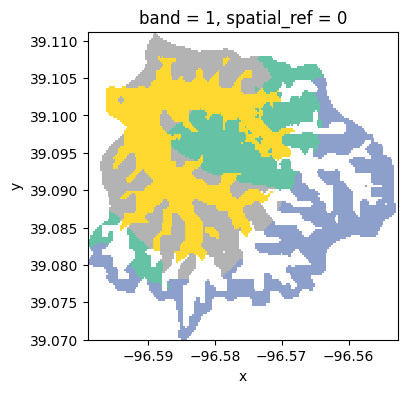

In [173]:
# Read GeoTiff file using the Xarray package
raster = xr.open_dataarray(filename).squeeze()

#fig, ax = plt.subplots(1,1,figsize=(6,5))
raster.plot(cmap='Set2', figsize=(4,4), add_colorbar=False);


## Example 2: State-level clustering

In this tutorial we will identify macroregions across Kansas determined by climate and soil variables.


### Load region


In [102]:
# Read US states
US_states = ee.FeatureCollection("TIGER/2018/States")

# Select Kansas
kansas = US_states.filter(ee.Filter.eq('NAME','Kansas'))

### Prepare clustering dataset

In [135]:
# Import image layers
ppt = ee.ImageCollection('OREGONSTATE/PRISM/Norm91m').select('ppt').sum().resample('bicubic')
tmean = ee.ImageCollection('OREGONSTATE/PRISM/Norm91m').select('tmean').mean().resample('bicubic')
vpdmax = ee.ImageCollection('OREGONSTATE/PRISM/Norm91m').select('vpdmax').mean().resample('bicubic')
soil = ee.Image("projects/soilgrids-isric/sand_mean").select('sand_0-5cm_mean').resample('bicubic')

# Merge layers into a single dataset
dataset = ppt.addBands(soil).addBands(tmean).addBands(vpdmax)


### Generate clusters

In [136]:
# Select random points across the image in the defined region for training
sample_points = dataset.sample(region=kansas, scale=1000, numPixels=1000)


In [137]:
# Define number of cluster to classify
cluster_number = 9
classificator = ee.Clusterer.wekaKMeans(cluster_number).train(sample_points)


### Reduce image to vectors

In [138]:
# Generate the clusters for the whole region
clusters = dataset.cluster(classificator).reduceToVectors(scale=1000, geometry=kansas).getInfo()


### Interactive plot

In [139]:
# Create Folium Map
m = folium.Map(location=[38.5, -98.5], zoom_start=7)

cmap = get_cmap('Set1',n=cluster_number)
cluster_layer = folium.GeoJson(clusters, name="Kansas", 
                               style_function=lambda x:get_polygon_color(x,cmap))
cluster_layer.add_to(m)

m

### Export clusters as GeoTIFF

In [140]:
# Create mask
mask = ee.Image.constant(1).clip(kansas).mask()


In [141]:
# Create image URL
image_url = dataset.cluster(classificator).mask(mask).getDownloadUrl({
    'region': kansas.geometry(),
    'scale':1000,
    'crs': 'EPSG:4326',
    'format': 'GEO_TIFF'
})


In [142]:
# Request data using URL and save data as a new GeoTiff file
response = requests.get(image_url)
filename = '../outputs/kansas_clusters.tif'
with open(filename, 'wb') as f:
    f.write(response.content)
  

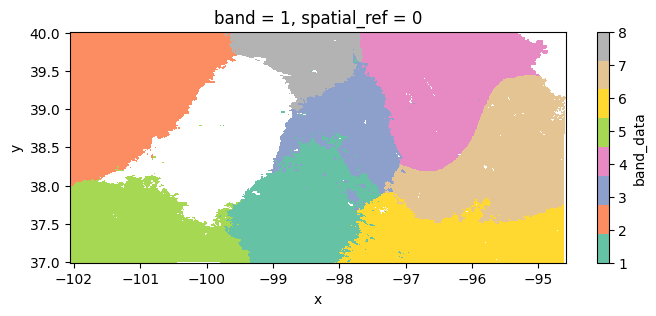

In [143]:
# Read GeoTiff file using the Xarray package
raster = xr.open_dataarray(filename).squeeze()

#fig, ax = plt.subplots(1,1,figsize=(6,5))
raster.plot(cmap='Set2', figsize=(8,3));
